## We now attempt to find out if the footnotes of the SEC filing has an effect on the transaction

In [4]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

import scipy.stats as stats

import statsmodels.api as sm

# Remove warnings to keep outputs clean
warnings.filterwarnings("ignore")

PROCESSED_DATA_FOLDER = "../../data_untracked/processed"
ABNORMAL_CSV = "merged_txns_SNORKEL.csv"

COMPILED_DATA_FOLDER = "../../data_untracked/raw/sec_submissions/compiled"
FOOTNOTES_CSV = "FOOTNOTES.csv"

### Download this if haven't

In [5]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download("wordnet")
# nltk.download("averaged_perceptron_tagger")

## Load required datasets
1. `snorkel_labels.csv`: Transactions with their Cumulative Abnormal Returns (CAR)
2. `FOOTNOTES.csv`: Each transactions with their individual filing comments

In [6]:
abnormal_transactions = pd.read_csv(f'{PROCESSED_DATA_FOLDER}/{ABNORMAL_CSV}')[["ACCESSION_NUMBER", "TRANS_CODE", "TRANS_ACQUIRED_DISP_CD", "snorkel_prob", "snorkel_pred"]]
abnormal_transactions = abnormal_transactions.rename(columns={"snorkel_prob" : "probability",
                                                               "snorkel_pred" : "prediction"})
footnotes = pd.read_csv(f'{COMPILED_DATA_FOLDER}/{FOOTNOTES_CSV}')
print("Loading data")

Loading data


In [7]:
print(abnormal_transactions.shape)
print(footnotes.shape)

(3171001, 5)
(7270873, 3)


In [8]:
footnotes.head()

,ACCESSION_NUMBER,FOOTNOTE_ID,FOOTNOTE_TXT
0,0001179110-14-011078,F1,Sale made pursuant to a Rule 10b5-1 Plan dated...
1,0001179110-14-011078,F2,Shares adjusted for those withheld to cover ta...
2,0001144204-14-040534,F3,"Includes 2,106 shares of common stock received..."
3,0001144204-14-040534,F2,Restricted shares of common stock issued pursu...
4,0001144204-14-040534,F1,Shares issued in lieu of cash for board services.


In [9]:
## Combine each accession number footnotes
df_footnote = footnotes.copy()
df_footnote = df_footnote.sort_values(by=["ACCESSION_NUMBER", "FOOTNOTE_ID"])
df_footnote["FOOTNOTE_TXT"] = df_footnote["FOOTNOTE_TXT"].astype(str)
df_grouped = df_footnote.groupby("ACCESSION_NUMBER", sort=True)["FOOTNOTE_TXT"].apply(lambda x: " ".join(x)).reset_index()
df_grouped

,ACCESSION_NUMBER,FOOTNOTE_TXT
0,0000001750-06-000002,I disclaim any beneficial interest in these sh...
1,0000001750-06-000004,I disclaim any beneficial interest in these sh...
2,0000001750-06-000015,Reload option resulting from withholding of st...
3,0000001750-06-000016,I disclaim any beneficial interest in these sh...
4,0000001750-06-000017,Reload option resulting from withholding of st...
...,...,...
2830943,0001898927-21-000004,Represents restricted stock units (RSUs) grant...
2830944,0001899338-21-000001,Includes shares issued pursuant to the dividen...
2830945,0001899338-21-000002,Includes shares issued pursuant to the divided...
2830946,0001899338-21-000003,Includes shares issued pursuant to the dividen...


In [10]:
## Merge with the labelled data
df_footnote_combined = pd.merge(abnormal_transactions, df_grouped, how = "left", left_on = "ACCESSION_NUMBER", right_on = "ACCESSION_NUMBER")
df_footnote_combined = df_footnote_combined[df_footnote_combined["FOOTNOTE_TXT"].notnull()]
df_footnote_combined.head()

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,probability,prediction,FOOTNOTE_TXT
0,0001181431-09-023155,S,D,1.000000,1,Such options are currently exercisable as rega...
20,0000913165-18-000034,S,D,0.896270,1,Shares were disposed of pursuant to an Agreeme...
22,0000891092-06-003783,S,D,0.457921,0,In accordance with Rule 16(b) promulgated unde...
23,0000891092-06-003782,S,D,0.092176,0,In accordance with Rule 16(b) promulgated unde...
24,0000891092-06-003783,S,D,0.457921,0,In accordance with Rule 16(b) promulgated unde...


In [11]:
## Drop duplicates
df_footnote_exist_drop = df_footnote_combined.dropna(subset=["prediction"]).dropna(subset=["FOOTNOTE_TXT"])
df_footnote_exist_drop = df_footnote_exist_drop.drop_duplicates(subset=["ACCESSION_NUMBER"])
df_footnote_exist_drop.shape

(879169, 6)

In [12]:
## Create a lemmatizer function to be used later
lemmatizer = WordNetLemmatizer()

## Create a stop word to remove simple words
stop_words = set(stopwords.words("english"))
stop_words.update(["shall", "should"])

In [13]:
def get_wordnet_pos(nltk_tag):
    """ This function attempts to categorize the words that comes in

    Args:
        nltk_tag (str): A string that will be tagged

    Returns:
        str: A part of speech tagged
    """
    if nltk_tag.startswith("J"):  # Adjective
        return wordnet.ADJ
    elif nltk_tag.startswith("N"):  # Noun
        return wordnet.NOUN
    elif nltk_tag.startswith("V"):  # Verb
        return wordnet.VERB
    elif nltk_tag.startswith("R"):  # Adverb
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if unknown

In [14]:
def lemmatize_text(text):
    """ This function will lemmatize words to their base form: forced -> force

    Args:
        text (str): A sentence of words 

    Returns:
        str: A sentence that has words reduced to lemmatized form
    """
    words = word_tokenize(text)  # Tokenize text
    tagged_words = pos_tag(words)  # POS tagging

    lemmatized_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_words if lemmatizer.lemmatize(word, get_wordnet_pos(tag)) not in  stop_words
    ]

    return " ".join(lemmatized_words)  # Reconstruct sentence

In [15]:
def remove_words(text):
    """Remove numbers, months, days and unnecessary text

    Args:
        text (str): A sentence of words

    Returns:
        str: Trimmed sentence, removing unnecessary stuff
    """
    text = re.sub(r"[0-9,.%\$\"\(\)\/_]+", "", text)
    text = re.sub(r"(january|february|march|april|may|june|july|august|september|october|november|december|\
                  monday|tuesday|wednesday|thursday|friday)", "", text)
    return text

In [16]:
def preprocess_text(text):
    """Cleans a text by uncapitalizing, removing words and lemmatizing them

    Args:
        text (str): A sentence of words

    Returns:
        str: A cleaned sentence
    """
    text = text.lower()
    removed_unecessary_text = remove_words(text)
    lemmatized_text = lemmatize_text(removed_unecessary_text)

    return lemmatized_text

### Sample processed texts

In [17]:
preprocess_text("The striped cats were running quickly towards the biggest trading house.") 

'striped cat run quickly towards big trading house'

In [18]:
preprocess_text("This transaction was executed in multiple trades at prices ranging from $38.17 to $38.73. The price reported above reflects the weighted average sale price. The reporting person hereby undertakes to provide upon request to the SEC staff, the issuer or a security holder of the issuer full information regarding the number of shares and prices at which the transaction was effected.")

'transaction execute multiple trade price range price report reflect weighted average sale price report person hereby undertakes provide upon request sec staff issuer security holder issuer full information regard number share price transaction effect'

In [19]:
preprocess_text("forced sale")

'force sale'

## Find in samples

In [20]:
df_footnote_labels = df_footnote_exist_drop.copy()
df1, df2 = train_test_split(df_footnote_labels, test_size=0.25, random_state=4263)
sampled_df = df1
sampled_df.shape

(659376, 6)

In [21]:
sampled_df

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,probability,prediction,FOOTNOTE_TXT
1009753,0001209191-14-064158,S,D,0.090053,0,The shares covered by this Form 4 have been so...
563383,0001209191-07-026217,S,D,0.090053,0,Dividend reinvestment shares acquired. Sale pu...
473193,0001127602-16-060288,S,D,1.000000,1,1 for 1 Units are to be settled in cash after ...
3018219,0001127602-18-036365,P,A,0.524360,0,Shares purchased pursuant to 10b5-1 plan 2018-...
274662,0000721683-15-000040,S,D,0.090053,0,Includes shares acquired through exempt purcha...
...,...,...,...,...,...,...
2959064,0001209191-11-060642,P,A,0.500000,0,This Form 4 is a joint filing with the sole ow...
97575,0001209191-07-061951,J,D,1.000000,1,The reporting person expressly disclaims benef...
2129281,0001209191-20-041272,G,D,0.999998,1,Represents shares that have been withheld by t...
2741225,0001292960-09-000002,I,A,1.000000,1,Includes shares for restricted stock grants: ...


### Create prepocessed text from footnote and also create TF-IDF vector for word importance

In [22]:
text = sampled_df["FOOTNOTE_TXT"]
sampled_df["processed_txt"] = sampled_df["FOOTNOTE_TXT"].apply(lambda row: preprocess_text(row))

# processed = np.array([preprocess_text(x) for x in text])
vectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True, max_features=500)
X = vectorizer.fit_transform(sampled_df["processed_txt"])

# Convert to DataFrame
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())


In [23]:
tfidf_df.head()

,accordance,accordingly,account,accrue,achieve,achievement,acquire,acquisition,act,actual,...,wife,william,withhold,withholding,wp,write,wynnefield,xi,year,york
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.307115,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.172767,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
tfidf_df["prediction"] = sampled_df["prediction"]

In [25]:
# Sort the suspicious words for non-j coded items

suspicius = tfidf_df[tfidf_df['prediction'] == 1].drop(columns=["prediction"]).mean()
non_suspicious = tfidf_df[tfidf_df['prediction'] == 0].drop(columns=["prediction"]).mean()
suspicious_words = (suspicius - non_suspicious).sort_values(ascending=False)

### Create TF-IDF for word importance for J-Coded transactions as they were deemed to be suspicious by the paper

In [26]:
df_j_coded = df_footnote_labels[df_footnote_labels["TRANS_CODE"] == "J"]
df_j_coded.head()

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,probability,prediction,FOOTNOTE_TXT
50,0000891092-07-001488,J,D,0.090053,0,In a Form 4 filed with the Securities and Exch...
400,0001181431-06-016208,J,D,1.000000,1,Represents shares beneficially owned by the Al...
401,0001181431-06-017619,J,D,1.000000,1,"Reflects a distribution of 10,000 shares from ..."
671,0001209191-19-008111,J,D,0.961425,1,The transactions reported on this Form relate ...
672,0001214659-19-003175,J,D,0.518041,0,This statement is jointly filed by Royal Bank ...


In [27]:
text_j = df_j_coded["FOOTNOTE_TXT"]
processed = np.array([preprocess_text(x) for x in text_j])
vectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True, max_features=500)
X = vectorizer.fit_transform(processed)

# Convert to DataFrame
tfidf_df_j = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [28]:
tfidf_df_j["prediction"] = df_j_coded["prediction"]
tfidf_df_j.head()

,accel,accordance,accordingly,account,accrue,achieve,achievement,acquire,acquisition,act,...,wholly,wife,withhold,withholding,wp,xi,year,york,yorktown,prediction
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.190187,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057225,0.000000,0.206948,...,0.124955,0.0,0.0,0.0,0.0,0.0,0.0,0.118493,0.0,NaN


In [29]:
suspicius_j = tfidf_df_j[tfidf_df_j['prediction'] == 1].drop(columns=["prediction"]).mean()
non_suspicious_j = tfidf_df_j[tfidf_df_j['prediction'] == 0].drop(columns=["prediction"]).mean()
suspicious_words_j = (suspicius_j - non_suspicious_j).sort_values(ascending=False)

### Word importance plot by taking a difference between labelled 1 and labelled 0

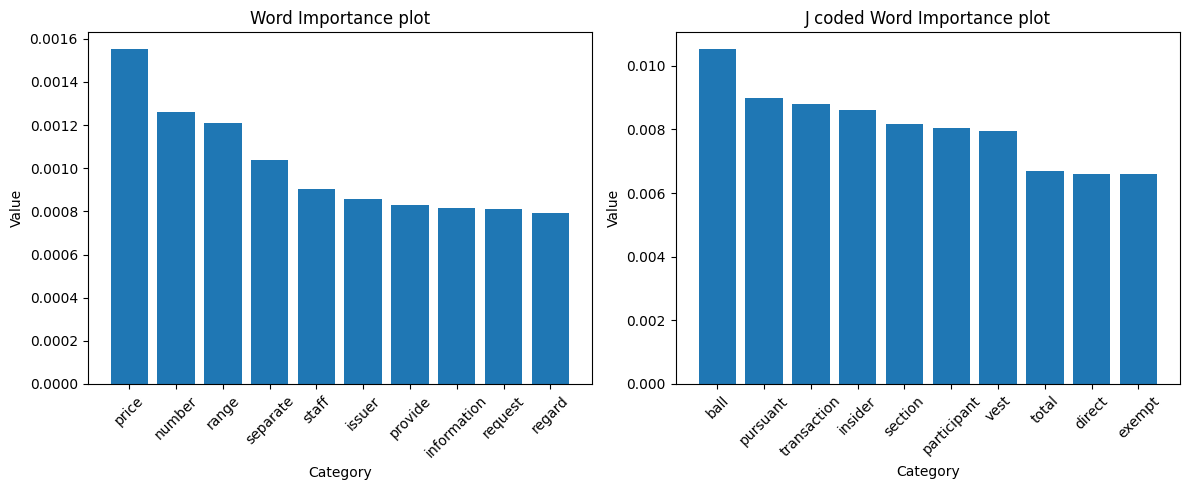

In [30]:
# Top 10 suspicious words Non-J coded and J coded
top_10_data = suspicious_words.head(10)
top_10_data_j = suspicious_words_j.head(10)

plt.figure(figsize=(12, 5))

########################
# Plot Non-J coded word importance
########################
plt.subplot(1, 2, 1)
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Word Importance plot')
plt.bar(top_10_data.index, top_10_data.values)
plt.xticks(rotation=45)

########################
# Plot J coded word importance
########################
plt.subplot(1, 2, 2)
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('J coded Word Importance plot')
plt.bar(top_10_data_j.index, top_10_data_j.values)

# Adjust layout and show
plt.tight_layout()
plt.show()


### Words like sell, trading, lieu and fee would be tested for significance

___
## Importance of features
___

### Feature creation:

In [31]:
## Count processed keywords
def count_lemmatized(row, string):
    processed_text = preprocess_text(row)
    processed_string = preprocess_text(string)
    occurance = processed_text.count(processed_string)
    return occurance

In [32]:
count_lemmatized("The reporting person received a grant of 375 restricted stock units of Adams Resources & Energy, \
                 Inc. (AE) on June 29, 2018.  Each restricted stock unit represents a contingent right to receive one\
                 share of AE common stock upon vesting. The restricted stock units will vest (i.e., the restrictions will lapse)\
                 on May 8, 2019, provided the reporting person remains in continuing active service on the vesting date (subject to accelerated vesting in some circumstances).",
                 "restricted")

4

### Words and codes like force sale, git, distribution, charity, "10b5-1" and "16b-3" would be tested for significance. These were taken directly from the paper

In [34]:
## Items to check
text_list = ["force sale", "gift", "distribution", "charity"] # From research paper
text_from_keywords = ["price", "number", "ball", "pursuant"] # From TF-IDF 
text_code = ["10b5-1", "16b-3"] # Trading codes from research paper

text_list.extend(text_from_keywords)
df_features = df_footnote_labels.copy()

print("Creating processed footnotes")
df_features["processed"] = df_features["FOOTNOTE_TXT"].apply(lambda row: preprocess_text(row))

for text in text_list:
    print(f"Creating feature for {text}")
    df_features[text] = df_features["processed"].str.count(preprocess_text(text))

for code in text_code:
    print(f"Creating feature for {code}")
    df_features[code] = df_features["FOOTNOTE_TXT"].str.count(code)
    

text_list = text_list + ["probability", "prediction"]
df_features = df_features[text_list + text_code]
df_features.head()

Creating processed footnotes
Creating feature for force sale
Creating feature for gift
Creating feature for distribution
Creating feature for charity
Creating feature for price
Creating feature for number
Creating feature for ball
Creating feature for pursuant
Creating feature for 10b5-1
Creating feature for 16b-3


,force sale,gift,distribution,charity,price,number,ball,pursuant,probability,prediction,10b5-1,16b-3
0,0,0,0,0,0,0,0,0,1.000000,1,0,0
20,0,0,0,0,0,0,0,1,0.896270,1,0,0
22,0,0,0,0,0,0,0,0,0.457921,0,0,0
23,0,0,0,0,0,0,0,0,0.092176,0,0,0
50,0,0,0,0,0,0,0,0,0.090053,0,0,0


In [ ]:
for col in df_features.columns:
    if col == "probability" or col == "prediction":
        continue
    print(f'{col}: {sum(df_features[col])}')

force sale: 4
gift: 3809
distribution: 5801
charity: 127
sell: 184495
trading: 44114
lieu: 761
fee: 2485
10b5-1: 56184
16b-3: 3032


In [35]:
##################################
# Define functions
##################################

def compare_complement(df, col, metrics):
    split_1 = df[df[col] >= 1]
    split_2 = df[df[col] < 1]
    
    for metric in metrics:
        A = split_1[metric].dropna()
        
        # print(A)
        B = split_2[metric].dropna()
        t_stat, p_val = stats.ttest_ind(A, B, equal_var=False)
        sign = "negative" if t_stat < 0 else "positive"
        print(f"{metric}: is more {sign} when {col} is separated\n" 
              f"t-statistic = {t_stat}, p-value = {p_val}\n"
              f"mean {col} = {np.mean(A)}, mean {col} complement = {np.mean(B)}\n")
        
    print(f"{col}: n = {len(A)}, {col} complement: n = {len(B)}\n")

def compare_columns(df, col1, col2, metrics):
    split_1 = df[df[col1] == 1]
    split_2 = df[df[col2] == 1]
    
    for metric in metrics:
        A = split_1[metric].dropna()
        
        B = split_2[metric].dropna()
        t_stat, p_val = stats.ttest_ind(A, B, equal_var=False)
        sign = "negative" if t_stat < 0 else "positive"
        print(f"{metric}: is more {sign} when {col1} compared to {col2}\n" 
              f"t-statistic = {t_stat}, p-value = {p_val}\n"
              f"mean {col1} = {np.mean(A)}, mean {col2} = {np.mean(B)}\n")
    print(f"{col1}: n = {len(A)}, {col2} : n = {len(B)}")

In [36]:
metrics = ["probability", "prediction"]

In [37]:
df_features.columns

Index(['force sale', 'gift', 'distribution', 'charity', 'price', 'number',
       'ball', 'pursuant', 'probability', 'prediction', '10b5-1', '16b-3'],
      dtype='object')

In [38]:
compare_complement(df_features,"force sale", metrics)

probability: is more positive when force sale is separated
t-statistic = 0.3672413809817833, p-value = 0.7185683817893846
mean force sale = 0.7097227278788613, mean force sale complement = 0.6763780092923193

prediction: is more positive when force sale is separated
t-statistic = 0.5836975295309811, p-value = 0.5680975953619929
mean force sale = 0.5625, mean force sale complement = 0.4877353543694897

force sale: n = 16, force sale complement: n = 879153



In [39]:
compare_complement(df_features,"gift", metrics)

probability: is more positive when gift is separated
t-statistic = 39.02763984262886, p-value = 0.0
mean gift = 0.7631028400005394, mean gift complement = 0.6743022535034751

prediction: is more positive when gift is separated
t-statistic = 40.867042127533445, p-value = 0.0
mean gift = 0.6242642408911806, mean gift complement = 0.4844679552580211

gift: n = 20557, gift complement: n = 858612



In [40]:
compare_complement(df_features,"distribution", metrics)

probability: is more positive when distribution is separated
t-statistic = 4.409693019925005, p-value = 1.0401141073608554e-05
mean distribution = 0.6863158853183959, mean distribution complement = 0.6761383023306954

prediction: is more positive when distribution is separated
t-statistic = 1.3919183053756945, p-value = 0.1639613554500626
mean distribution = 0.49250927308637216, mean distribution complement = 0.48762129984506236

distribution: n = 20759, distribution complement: n = 858410



In [41]:
compare_complement(df_features,"charity", metrics)

probability: is more positive when charity is separated
t-statistic = 10.639461687905623, p-value = 9.25032442477227e-25
mean charity = 0.7935943691820909, mean charity complement = 0.6762758654128095

prediction: is more positive when charity is separated
t-statistic = 10.414446416967019, p-value = 7.477630681199374e-24
mean charity = 0.6649350649350649, mean charity complement = 0.4875813838585882

charity: n = 770, charity complement: n = 878399



In [43]:
compare_complement(df_features,"price", metrics)

probability: is more positive when price is separated
t-statistic = 28.33494531258447, p-value = 1.587350532120655e-176
mean price = 0.6888646156641853, mean price complement = 0.6680043780083851

prediction: is more positive when price is separated
t-statistic = 32.405008088440866, p-value = 3.360746797666757e-230
mean price = 0.5088230794077147, mean price complement = 0.4735942960410922

price: n = 352938, price complement: n = 526231



In [44]:
compare_complement(df_features,"number", metrics)

probability: is more positive when number is separated
t-statistic = 31.687259302207142, p-value = 3.4455665496968163e-220
mean number = 0.6918180229930755, mean number complement = 0.667933228930411

prediction: is more positive when number is separated
t-statistic = 34.512467214816645, p-value = 9.089051684139467e-261
mean number = 0.5126035822739204, mean number complement = 0.474134487643079

number: n = 310864, number complement: n = 568305



In [45]:
compare_complement(df_features,"ball", metrics)

probability: is more negative when ball is separated
t-statistic = -24.129089277910413, p-value = 1.0269669284418017e-113
mean ball = 0.5281831120823093, mean ball complement = 0.6767303977001838

prediction: is more negative when ball is separated
t-statistic = -31.544043145711985, p-value = 4.7512446755260554e-179
mean ball = 0.207492795389049, mean ball complement = 0.4884019487234448

ball: n = 2082, ball complement: n = 877087



In [46]:
compare_complement(df_features,"pursuant", metrics)

probability: is more negative when pursuant is separated
t-statistic = -51.91100973675548, p-value = 0.0
mean pursuant = 0.6547523172118688, mean pursuant complement = 0.6926983665637906

prediction: is more negative when pursuant is separated
t-statistic = -45.05789183293862, p-value = 0.0
mean pursuant = 0.4601294328913996, mean pursuant complement = 0.5085698661631987

pursuant: n = 378111, pursuant complement: n = 501058



In [47]:
compare_complement(df_features, "10b5-1", metrics)

probability: is more negative when 10b5-1 is separated
t-statistic = -49.96149750663826, p-value = 0.0
mean 10b5-1 = 0.6499232353645202, mean 10b5-1 complement = 0.6889097178520565

prediction: is more negative when 10b5-1 is separated
t-statistic = -39.484488883920775, p-value = 0.0
mean 10b5-1 = 0.4572198001302268, mean 10b5-1 complement = 0.5021916407552989

10b5-1: n = 282584, 10b5-1 complement: n = 596585



In [48]:
compare_complement(df_features, "16b-3", metrics)

probability: is more negative when 16b-3 is separated
t-statistic = -7.656129414831334, p-value = 1.9867601741354002e-14
mean 16b-3 = 0.6587672442328695, mean 16b-3 complement = 0.676859396218307

prediction: is more negative when 16b-3 is separated
t-statistic = -0.8225050385864122, p-value = 0.41079747480128803
mean 16b-3 = 0.48508325129478236, mean 16b-3 complement = 0.4878091530089763

16b-3: n = 23363, 16b-3 complement: n = 855806



### Words like fee, lieu, charity, gift and force sale does not appear to have large significance, but now they will be checked for their significance when fitted in a log regression

## Train test split on binary labels

In [49]:
labels = ["prediction", "probability"]

In [50]:
df_features

,force sale,gift,distribution,charity,price,number,ball,pursuant,probability,prediction,10b5-1,16b-3
0,0,0,0,0,0,0,0,0,1.000000,1,0,0
20,0,0,0,0,0,0,0,1,0.896270,1,0,0
22,0,0,0,0,0,0,0,0,0.457921,0,0,0
23,0,0,0,0,0,0,0,0,0.092176,0,0,0
50,0,0,0,0,0,0,0,0,0.090053,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3170995,0,0,0,0,3,1,0,0,0.983276,1,0,0
3170996,0,0,0,0,0,0,0,1,0.854588,1,0,0
3170997,0,0,0,0,0,0,0,0,0.524360,0,0,0
3170998,0,0,0,0,0,0,0,1,0.786723,0,0,0


In [51]:
df_log = df_features.copy()
df_log = df_log.dropna(subset=labels)
X, y = df_log.drop(columns=labels), df_log[labels[1]]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=123)
print(f"train size x: {train_x.shape}\ntrain size y: {train_y.shape}\ntest size x: {test_x.shape}\ntest size y: {test_y.shape}")

train size x: (703335, 10)
train size y: (703335,)
test size x: (175834, 10)
test size y: (175834,)


## Fit log regression on labels

#["price", "number", "ball", "pursuant

In [52]:
def find_significance(data, columns, label):
    data = data.dropna(subset=[label])
    X = data[columns]
    y = data[label]
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=123)
    
    X_with_const = sm.add_constant(train_x)
    model = sm.Logit(train_y, X_with_const).fit()

    print(model.summary())

In [58]:
variables = ["force sale", "gift", "distribution", "charity", "price", "number", "ball", "pursuant", "10b5-1", "16b-3"]
label = "probability"
find_significance(df_features, variables, label)

Optimization terminated successfully.
         Current function value: 0.600291
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            probability   No. Observations:               703335
Model:                          Logit   Df Residuals:                   703324
Method:                           MLE   Df Model:                           10
Date:                Thu, 03 Apr 2025   Pseudo R-squ.:                -0.03570
Time:                        13:38:21   Log-Likelihood:            -4.2221e+05
converged:                       True   LL-Null:                   -4.0765e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.7950      0.003    238.176      0.000       0.788       0.802
force sale       0.5847

In [59]:
## Remove force sale
variables.remove("force sale")
label = "probability"
find_significance(df_features, variables, label)

Optimization terminated successfully.
         Current function value: 0.600292
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            probability   No. Observations:               703335
Model:                          Logit   Df Residuals:                   703325
Method:                           MLE   Df Model:                            9
Date:                Thu, 03 Apr 2025   Pseudo R-squ.:                -0.03570
Time:                        13:38:27   Log-Likelihood:            -4.2221e+05
converged:                       True   LL-Null:                   -4.0765e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.7950      0.003    238.181      0.000       0.788       0.802
gift             0.2543

### Hence as above, we have removed the words highlighted and are left with the below key words

In [62]:
print(variables)

['gift', 'distribution', 'charity', 'price', 'number', 'ball', 'pursuant', '10b5-1', '16b-3']


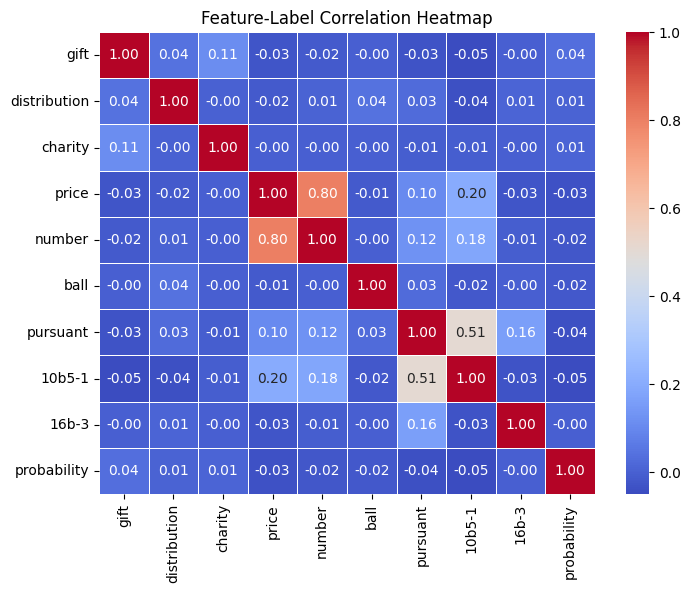

In [63]:
label = "probability"

corr_feature = df_features[variables + [label]]

corr = corr_feature.corr(method="pearson")
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature-Label Correlation Heatmap")
plt.show()

### Price and Numbers are correlated but we'll leave it in to see how it performs in the model